In [1]:
%load_ext line_profiler

In [2]:
from IPython.core.display import display, HTML
#display(HTML('<style>.container {width:100% !important;} <\style>'))

In [3]:
from trivariatevectorlinearinterpolation import LinearAimAssister, LinearEigenvectorInterpolator, Dp54Linear

In [4]:
from auxiliarypointstuff import cy_compute_pos_aim, cy_cross_product, \
                                cy_in_plane, cy_orthogonal_component, \
                                cy_parallel_component, cy_normalize, \
                                cy_norm2, cy_min

In [5]:
from ndcurvebsplineinterp import NDCurveBSplineInterpolator # <= Krever Fortran-Python-kobling

In [6]:
from trivariatevectorbsplineinterpolation import SplineAimAssister, SplineEigenvectorInterpolator, Dp54BSpline
# ^ Krever Fortran-Python-kobling

In [7]:
from trivariatescalarinterpolation import TrivariateSpline
# ^ Krever Fortan-Python-kobling

In [8]:
import sys
sys.path.insert(0,'../..') # Sett inn det som trengs for at numerical_integrators
                           # blir tilgjengelig i path

In [9]:
from numerical_integrators.singlestep import rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkdp54,rkdp87

In [10]:
import multiprocessing as mp
import numpy as np
import numba as nb
import math
import time

In [63]:
import matplotlib as mpl
mpl.use("pgf")

#################################################
##### Fjern kommentarer for bonus-stilpoeng #####
#################################################

# Custom matplotlib config (fonts etc)

# TeX preamble
#pgf_with_pdflatex = {
#    "font.family": "serif",
#    "text.usetex": True,
#    "text.latex.unicode": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",
#         r"\usepackage[T1]{fontenc}",
#         r"\usepackage[]{libertine}"
#         r"\usepackage[libertine]{newtxmath}"
#         ]
#}
#mpl.rcParams.update(pgf_with_pdflatex)


#mpl.rcParams['font.family'] = 'Libertine'

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

#import matplotlib.font_manager as fm
#prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

from matplotlib import pyplot as plt
from matplotlib import tri as mtri
#plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/ana

In [12]:
def f(t,x,A=np.sqrt(3),B=np.sqrt(2),C=1):
    """ A function which computes the right hand side(s) of the coupled equation of variations
    for the flow map Jacobian, for steady ABC flow.
    
    param: t -- Time
    param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                Shape: (12,nx,ny,nz)
    OPTIONAL:
    param: A -- Default: A = sqrt(3)
    param: B -- Default: B = sqrt(2)
    param: C -- Default: C = 1
    
    return: Twelve-component array, containing the (component-wise) right hand side of the
            coupled equation of variations
            Shape: (12,nx,ny,nz)
    """
    ret = np.empty(x.shape)
    ret[0] = A*np.sin(x[2]) + C*np.cos(x[1])                # x-component of velocity field
    ret[1] = B*np.sin(x[0]) + A*np.cos(x[2])                # y-component of velocity field
    ret[2] = C*np.sin(x[1]) + B*np.cos(x[0])                # z-component of velocity field
    ret[3] = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]     # The remaining (coupled) entries 
    ret[4] = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]    # constitute the RHS of the 
    ret[5] = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]    # variational ODE for the 
    ret[6] = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]     # flow map Jacobian
    ret[7] = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8] = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9] = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,func,integ,nproc=4):
    """A function which computes the eigenvalues and -vectors for the Cauchy-Green 
    strain tensor for a given velocity field in a given time interval, on a 
    regular Cartesian grid.
    
    param: t0 -- Start time
    param: x  -- (NumPy) array of abscissae values along the x-axis, i.e., 
                 the x-values of the points in the computational grid.
    param: y  -- (NumPy) array of abscissae values along the y-axis, i.e., 
                 the y-values of the points in the computational grid.
    param: z  -- (NumPy) array of abscissae values along the z-axis, i.e., 
                 the z-values of the points in the computational grid.
    param: tf -- End time
    param: h  -- (Initial) integration time step
    param: func -- Function handle, pointing to function returning the RHS
                   of the flow ODE system
    param: integ -- Function handle, pointing to function which performs
                    numerical integration (e.g., a Runge-Kutta solver)
    OPTIONAL:
    param: nproc -- The number of available cores for multiprocessing. 
                    Default: nproc=4
    
    return: lambdas -- 3-tuple of computed strain eigenvalues.
                       Sorted in ascending order. 
    return: xis     -- 3-tuple of computed (normalized) strain
                       eigenvectors. Sorted in the same order
                       as the eigenvalues.
    """
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc)
    u, s, v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (np.ascontiguousarray(lm1), np.ascontiguousarray(lm2), np.ascontiguousarray(lm3)), \
            (np.ascontiguousarray(xi1), np.ascontiguousarray(xi2), np.ascontiguousarray(xi3))
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    """A function which computes the final state of the flow map Jacobian for three-dimensional
    tracer advection.
    
    param: t0 -- Start time
    param: x  -- (NumPy) array of abscissae values along the x-axis, i.e., 
                 the x-values of the points in the computational grid.
    param: y  -- (NumPy) array of abscissae values along the y-axis, i.e., 
                 the y-values of the points in the computational grid.
    param: z  -- (NumPy) array of abscissae values along the z-axis, i.e., 
                 the z-values of the points in the computational grid.
    param: tf -- End time
    param: h  -- (Initial) integration time step
    param: func -- Function handle, pointing to function returning the RHS
                   of the flow ODE system
    param: integ -- Function handle, pointing to function which performs
                    numerical integration (e.g., a Runge-Kutta solver)
    param: nproc -- The number of available cores for multiprocessing. 
    
    return: jac -- (NumPy) array of final state Jacobian values, with shape
                   (nx,ny,nz,3,3)
    """
                                                                     
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j])
                    )
          for j in range(nproc)
         ]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    """A function which advects a slice of initial conditions from the initial 
    to the final state.
    
    param: t0 -- Start time
    param: pos -- (NumPy) array of initial conditions.
    param: tf -- End time
    param: h -- (Initial) integration step
    param: func -- Function handle, pointing to a function returning
                   the RHS of the flow ODE system
    param: integ -- Function handle, pointing to a function which
                    performs numerical integration (e.g., a Runge-Kutta solver)
    param: q -- Multiprocessing.Queue instance, in which the result is put.
    """
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [13]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [14]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:
(lm1,lm2,lm3), (xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,f,flowmap_integrator)

In [15]:
# Conceptual illustration of how to compute an AB subdomain of the original grid.
# Not currently used. 

#def find_points_in_ab(hess_lm3,lm3,lm2,xi3):
#    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
#    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
#    return np.logical_and(mask_a,mask_b)

In [16]:
# Currently not used - kept for future reference wrt parameters etc
#hlm3 = compute_hessian_lm(lm3,x,y,z)
#ask_ab = find_points_in_ab(hlm3,lm3,lm2,xi3)

In [17]:
# Make interpolation objects of lambda 1 through to 3
# Use at least fourth order in order to enforce all second derivatives to be continuous
lm1_itp = TrivariateSpline(x,y,z,lm1,kx=4,ky=4,kz=4,extrap=False)
lm2_itp = TrivariateSpline(x,y,z,lm2,kx=4,ky=4,kz=4,extrap=False)
lm3_itp = TrivariateSpline(x,y,z,lm3,kx=4,ky=4,kz=4,extrap=False)

In [18]:
linear_itp = True # <= Må være True så lenge Fortran-Python-kobling ikke er på plass

In [19]:
if linear_itp:
    xi1_itp = LinearEigenvectorInterpolator(x,y,z,xi1)
    xi2_itp = LinearEigenvectorInterpolator(x,y,z,xi2)
    xi3_itp = LinearEigenvectorInterpolator(x,y,z,xi3)
    direction_generator = LinearAimAssister(xi3_itp)
    dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
else:
    xi1_itp = SplineEigenvectorInterpolator(x,y,z,xi1,3,3,3)
    xi2_itp = SplineEigenvectorInterpolator(x,y,z,xi2,3,3,3)
    xi3_itp = SplineEigenvectorInterpolator(x,y,z,xi3,3,3,3)
    direction_generator = SplineAimAssister(xi3_itp)
    dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)

In [20]:
# Sinusoidal
sinusoidalsurface = not True # Nytt testcase; z = f(x,y) = sin(2x)*sin(2y) + pi

xi3_sinusoid = np.empty((nx,ny,nz,3))

xi3_sinusoid[...,0] = 2*np.cos(2*np.meshgrid(x,y,z,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,z,indexing='ij')[1])
xi3_sinusoid[...,1] = 2*np.sin(2*np.meshgrid(x,y,z,indexing='ij')[0])*np.cos(2*np.meshgrid(x,y,z,indexing='ij')[1])
xi3_sinusoid[...,2] = -1

xi3_sinusoid = (xi3_sinusoid.transpose(3,0,1,2) / np.linalg.norm(xi3_sinusoid,axis=3)).transpose(1,2,3,0)

In [21]:
if sinusoidalsurface:
    if linear_itp:
        xi3_itp_sinusoid = LinearEigenvectorInterpolator(x,y,z,xi3_sinusoid)
        direction_generator = LinearAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
    else:
        xi3_itp_sinusoid = SplineEigenvectorInterpolator(x,y,z,xi3_sinusoid,3,3,3)
        direction_generator = SplineAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)

In [22]:
# Spesiell lineærinterpolasjon gjøres nå på Cython-nivå, beholder koden i denne cellen som ref

#class LinearSpecialInterpolator:
#    """
#    LinearSpecialInterpolator(xi,x,y,z)
#        
#    A collection of methods to perform linear interpolation with direction correction,
#    of three-dimensional strain eigenvectors.
#        
#    param: xi -- NumPy array of shape (len(x),len(y),len(z),3), containing the eigenvectors xi
#                 given at the grid points spanned by x, y and z
#    param: x  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: y  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: z  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    
#    ******************************************************************************************
#    
#    Methods defined here:
#    
#    LinearSpecialInterpolator.__call__(x)
#    
#    Performs the aforementioned special linear interpolation of the eigenvector xi at
#    the point x.
#    
#    param: x -- Three-component NumPy array, containing the coordinates at which a linear
#                special interpolation of xi is sought; (x,y,z).
#        
#    return: Three-component NumPy array, containing the normalized linearly interpolated
#            xi value at the point x.
#    """
#    def __init__(self,xi,x,y,z):
#        self.xi = xi
#        self.nx = xi.shape[0]-1
#        self.ny = xi.shape[1]-1
#        self.nz = xi.shape[2]-1
#        self.dx = x[1]-x[0]
#        self.dy = y[1]-y[0]
#        self.dz = z[1]-z[0]
#        self.x_min = x[0]
#        self.x_max = x[self.nx-1]
#        self.y_min = y[0]
#        self.y_max = y[self.ny-1]
#        self.z_min = z[0]
#        self.z_max = z[self.nz-1]
#        self.version = '0.1' # To keep track of changes as we go along
#    
#    def __call__(self,x):
#        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
#        cubevecs = [self.xi[ix,iy,iz],
#                    self.xi[ixp1,iy,iz],
#                    self.xi[ix,iyp1,iz],
#                    self.xi[ixp1,iyp1,iz],
#                    self.xi[ix,iy,izp1],
#                    self.xi[ixp1,iy,izp1],
#                    self.xi[ix,iyp1,izp1],
#                    self.xi[ixp1,iyp1,izp1]]
#        # Flip vectors 180 degrees if they are rotated more than 90 degrees with regards to
#        # an arbitrary reference point within the interpolation voxel
#        for i in range(8):
#            if cubevecs[0].dot(cubevecs[i]) < 0:
#                cubevecs[i] = -cubevecs[i]
#        
#        # 
#        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
#    
#    def _compute_indices_and_weights(self,x,y,z):
#        """
#        param: x -- x-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: y -- y-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: z -- z-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#                    
#        return: x    -- Normalized relative coordinate within the interpolation voxel
#        return: ix   -- Index indicating the corners of the interpolation voxel
#        return: ixp1 -- Index indicating the corners of the interpolation voxel
#        return: y    -- Normalized relative coordinate within the interpolation voxel
 #       return: iy   -- Index indicating the corners of the interpolation voxel
 #       return: iyp1 -- Index indicating the corners of the interpolation voxel
 #       return: z    -- Normalized relative coordinate within the interpolation voxel
 #       return: iz   -- Index indicating the corners of the interpolation voxel
 #       return: izp1 -- Index indicating the corners of the interpolation voxel
 #       """
 #       x = np.fmod((x-self.x_min)/self.dx,self.nx)
 #       y = np.fmod((y-self.y_min)/self.dy,self.ny)
 #       z = np.fmod((z-self.z_min)/self.dz,self.nz)
 #       
 #       while x < 0:
 #           x += self.nx
 #       while y < 0:
 #           y += self.ny
 ##       while z < 0:
 #           z += self.nz
 #           
 #       ix = np.floor(x).astype(int)
 #       iy = np.floor(y).astype(int)
 #       iz = np.floor(z).astype(int)
 #       
 #       x -= ix
 #       y -= iy
 #       z -= iz
 #       
 #       ixp1 = int((ix+1)%self.nx)
 #       iyp1 = int((iy+1)%self.ny)
 #       izp1 = int((iz+1)%self.nz)
 #       
 #       return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
 #   
 #   @staticmethod
 #   def _normalized_weighted_sum(cubevecs,x,y,z):
 #       """
 #       param: cubevecs -- List of xi vectors defined at the corners of the interpolation voxel
 #       param:        x -- Normalized relative coordinate within the interpolation voxel
 #       param:        y -- Normalized relative coordinate within the interpolation voxel
 #       param:        z -- Normalized relative coordinate within the interpolation voxel
 #       
 #       return:     vec -- Normalized linearly interpolated xi vector 
 #       """
 #       vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
 #               +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
 #       return vec/np.linalg.norm(vec)

In [23]:
# Sikting gjøres nå på Cython-nivå. Beholder koden i denne cellen som ref.

#class AimAssister:
#    """
#    AimAssister(target,xi1,xi2)
#    
#    A collection of methods to assist with the process of computing the best
#    targetting aproximation of a point based on linear combinations of
#    the local eigenvectors xi1 and xi2.
#        
#    param: target -- NumPy array containing the coordinates of the point we're aiming for
#    param:    xi1 -- A LinearSpecialInterpolator instance, calibrated for xi1
#    param:    xi2 -- A LinearSpecialInterpolator instance, calibrated for xi2
#    
#    ****************************************************************************************
#    
#    Methods defined here:
#    
#    AimAssister.__call__(t,x)
#    
#    param: t -- Dummy variable, required when using an adaptive stepsize integrator to track
#                arclength (i.e., pseudotime)
#    param: x -- The current point, at which one wants to obtain the component of the
#                vector separating *this* and the target, within the plane spanned
#                by the local xi1 and xi2 vectors
#                    
#    return: Normalized 'best-estimate' vector component in the plane spanned by xi1 and xi2
#    """
#    def __init__(self, target, xi1, xi2):
#        self.target = target
#        self.xi1 = xi1
#        self.xi2 = xi2
#        self.a1 = False
#        self.a2 = False
#        self.fixed = False
#    
#    def __call__(self, t, x):
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        
#        if not self.fixed:
#            
#
#            r = self.target-x
#            r /= np.linalg.norm(r)
#
#            a1 = np.dot(xi1, r)
#            a2 = np.dot(xi2, r)
#        else:
#            a1 = self.a1
#            a2 = self.a2
#        
#        vec = a1*xi1 + a2*xi2
#        #print('a1 =', a1, 'a2 =', a2)
#        return vec/np.linalg.norm(vec)
#    
#    def fix(self,x):
#        r = self.target-x
#        r /= np.linalg.norm(r)
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        self.a1 = np.dot(xi1, r)
#        self.a2 = np.dot(xi2, r)
#        self.fixed = True

In [24]:
# Currently not used. See sinusoidal case above for how this could be done
# in the current environment, reducing the amount of code which needs
# to be changed in the next couple of cells drastically.

# Dummy classes, which replace the LinearSpecialInterpolator instances
# in 'AimAssister' when a spherical shell is considered
#class Evec1:
#    def __call__(self,x):
#        vec = np.array([x[0]*x[2],x[1]*x[2],-x[1]**2-x[0]**2])
#        return vec/np.linalg.norm(vec)
#class Evec2:
#    def __call__(self,x):
#        vec=np.array([x[1],-x[0],0])
#        return vec/np.linalg.norm(vec)    

In [25]:
class Manifold:
    """A wrapper class for a collection of geodesic level sets which
    constitute an invariant manifold.
    
    Methods defined here:
    
    Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep)
    Manifold.add_level_sets(num_sets_to_add)
    Manifold.check_ab()
    Manifold.compute_lambda3_and_weights()
        
    """
  
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep
                ):
        """Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep)
        
        Initializes a Manifold object without adding any level sets.
                
        param: init_pos --     NumPy array containing the initial position (x,y,z)
                               from which the manifold is constructed
        param: dom_bound --    Domain boundaries, as a six-element list.
                               Format: [xmin, xmax, ymin, ymax, zmin, zmax]
        param: max_geo_dist -- Maximum geodesic distance. Used to terminate
                               development of manifold
        param: min_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: max_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: dist --         The (initial) radial distance from each
                               point in a given level set, to the 
                               'radially connected' point in the
                               construction of the next level set
        param: dist_tol --     Numerical tolerance parameter for the
                               above. 0 <= dist_tol <= 1
        param: plane_tol --    Numerical tolerance parameter for the acceptance of
                               points as members of a plane
        param: tan_tol --      Tolerance for angular offset between consecutive
                               tangential (half-plane defining) vectors
                               (used in normalized dot product)
        param: min_ang --      Minimal radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is 
                               constructed
        param: max_ang --      Maximal radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_dist_ang -- Minimal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is
                               constructed
        param: max_dist_ang -- Maximal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_sep --      Minimal distance allowed between
                               (neighboring) points in a level set.
        param: max_sep --      Maximal distance allowed between
                               (neighboring) points in a level set        
        """
        self.levelsets    = []
        self.noise_gauge  = []
        self.dist         = dist
        self.num_sets     = 0
        self.geo_dist     = 0
        self.input_params = InputManifoldParameters(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, 
                                                     dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, 
                                                    max_dist_ang, min_sep, max_sep
                                                   )
        
    def add_level_sets(self, num_sets_to_add):
        """Manifold.add_level_sets(num_sets_to_add)
        
        Adds a specified number of geodesic level sets to the Manifold.
        
        Writes the number of points in each successfully added level set,
        as well as the elapsed time, to console.
        
        If no more geodesic level sets can be added, exceptions with
        descriptive names and docstrings are raised.
        
        param: num_sets_to_add -- The (integer) number of geodesic level sets to add.
        
        """
        n = 0
        try:
            if self.num_sets == 0 and num_sets_to_add > 0:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params))
                self.num_sets += 1
                n += 1
        except OutsideOfDomainError as e:
            print(e.value)
            print('Point near edge. Could not complete first level set. Returning empty manifold')
            return
        while (n < num_sets_to_add and self.geo_dist <= self.input_params.max_geo_dist):
            t_start = time.time()
            try:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params,
                                                      self.levelsets[self.num_sets-1])
                                     )
            except NeedSmallerDistError as e:
                try:
                    if (self.dist > self.input_params.min_sep):
                        self.dist = self.input_params.min_sep
                        try:
                            self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist,
                                                           self.input_params, self.levelsets[self.num_sets-1]))
                            ### Experimental ###
                            #self.levelsets[-1].next_dist = failed_dist
                        except NeedSmallerDistError as e:
                            print('Could not complete geodesic level set number {}'.format(n))
                            raise CannotDecreaseDistFurtherError('Cannot add more level sets without violating min_sep')
                            #raise RuntimeError('Failed to locate needed point at minimum step length.')
                    else:
                        raise CannotDecreaseDistFurtherError('Cannot add more level sets without violating min_sep')
                        #raise RuntimeError('Failed to locate needed point at minimum step length.')
                except (OutsideOfDomainError, CannotDecreaseDistFurtherError) as e:
                    print(e.value)
                    break
            #except CannotDecreaseDistFurtherError as e:
            #    print(e.value)
            #    break
        
            self.num_sets += 1
            self.geo_dist += self.dist
            self.dist = self.levelsets[-1].next_dist
            self.noise_gauge.append(self.geo_dist*2*np.pi/len(self.levelsets[-1].points))
            n += 1
            print('Level set {:4d} completed. Number of points: {:4d}. Cumulative geodesic distance: {:.3f}.'\
                  ' Elapsed time: {:.2f} seconds.'.format(len(self.levelsets), 
                                                        len(self.levelsets[-1].points), 
                                                        self.geo_dist, 
                                                        time.time() - t_start
                                                       )
                 )

            if (n > 10):
                if (np.mean(self.noise_gauge[-5:]) < 0.5*np.mean(self.noise_gauge[:-5])):
                    print('Numerical noise detected. Stopping.')
                    break
                    
        if (self.geo_dist > self.input_params.max_geo_dist):
            print('Max geodesic distance reached. No more level sets can be added in the current environment.')
    
    def check_ab(self):
        """Manifold.check_ab()
        
        Checks which of the points in the parametrization of the manifold
        satisfy the A- and B- criteria for (strong) LCSs.
        
        The boolean flag 'in_ab' for each of the Point instances in all
        the GeodesicLevelSet instances is set when this function is
        called.
        """
        for level in self.levelsets:
            for point in level.points:
                if (point.in_ab is None):
                    point._is_in_ab()
        print('Points in AB domain identified.')
        
    def compute_lambda3_and_weights(self):
        """Manifold.compute_lambda3_and_weights()
        
        Assigns a B-spline interpolated lambda3 value to each point in the manifold,
        in addition to a numerical weighting factor intended to approximate the
        part of the surface area of the manifold which is associated to each
        individual point.
        """
        for i, lset in enumerate(self.levelsets):#range(len(self.levelsets)):
        #for i in range(len(self.levelsets)):
            n = len(lset.points)
            #n = len(self.levelsets[i].points)
            for j, point in enumerate(lset.points):
            #for j in range(n):
                point.lambda3 = lm3_itp(point.pos)
                point.weight = 0.5*(lset.dist + self.levelsets[min(i+1,len(self.levelsets)-1)].dist)*\
                               0.5*(cy_norm2(point.pos - lset.points[np.divmod(j-1,n)[1]].pos)+
                                    cy_norm2(point.pos - lset.points[np.divmod(j+1,n)[1]].pos)
                                   )
                #self.levelsets[i].points[j].lambda3 = lm3_itp(self.levelsets[i].points[j].pos)
                #self.levelsets[i].points[j].weight = (self.levelsets[i].dist +
                #    self.levelsets[min(i+1,len(self.levelsets)-1)].dist)/2 * (np.linalg.norm(self.levelsets[i].points[j].pos -
                #    self.levelsets[i].points[np.divmod(j-1,n)[1]].pos) + np.linalg.norm(self.levelsets[i].points[j].pos -
                #    self.levelsets[i].points[np.divmod(j+1,n)[1]].pos))/2
        print('Point weights identified.')

In [26]:
class InputManifoldParameters:
    """A wrapper class for a set of parameters which define an invariant manifold
    parametrized in terms of geodesic level sets.
    
    Methods defined here:
    
    InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                     plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                     min_sep, max_sep
                                    )
        
    """

    # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):
        """InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                 plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                 min_sep, max_sep
                                )
        
        For most practical purposes, a dictionary disguised as a class, intended for use in the interaction
        between a Manifold instance and its constituent GeodesicLevelSet instances, in order to shorten
        the involved call signatures.
        """

        self.init_pos = init_pos
        self.max_geo_dist = max_geo_dist
        self.dom_bound = dom_bound
        self.min_s_step = min_s_step
        self.max_s_step = max_s_step
        self.dist_tol = dist_tol
        self.plane_tol = plane_tol
        self.tan_tol = tan_tol
        self.min_ang = min_ang
        self.max_ang = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep = min_sep
        self.max_sep = max_sep

In [27]:
class GeodesicLevelSet:
    """A wrapper class for a collection of points which
    parametrize a geodesic level set.
    
    Methods defined here:
    
    GeodesicLevelSet.__init__(level_num, dist, input_params, prev_set)
    GeodesicLevelSet._generate_first_set(input_params)
    GeodesicLevelSet._generate_set(dist, input_params, prev_set)
    GeodesicLevelSet._revise_set(set_suggestion, prev_set, input_params)
    GeodesicLevelSet._stabs_in_the_dark(index, prev_set, input_params, inbetween)
    GeodesicLevelSet._remove_loops(set_suggestion, min_sep, max_sep)
    """
    
    
    # Constructor
    def __init__(self, level_num, dist, input_params, prev_set=None):
        """GeodesicLevelSet.__init__(level_num, dist, input_params, prev_set)
        
        Constructor for a GeodesicLevelSet instance.
        
        param: level_num --    The (integer) number of geodesic level sets which have
                               been computed prior to this one. Only used to differentiate
                               between the base-case construction routine for the very
                               first level set, which is made to be a small, planar
                               circle, and all others, which are constructed by means
                               of trajectories orthogonal to a vector field.
        param: dist --         If level_num == 0: Ten times the radius of the initial
                               level set, approximated as a planar circle.
                               Else: The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: prev_set --     The GeodesicLevelSet instance representing the immediately
                               preceding geodesic level set in the manifold in question.
                               If None and level_num > 0: Raises an exception
        
        """
        
        self.dist = dist
        
        # Set in sub-functions: self.next_dist
        
        if (level_num == 0):
            new_set = self._generate_first_set(input_params)
        else:       
            set_suggestion = self._generate_set(dist, input_params, prev_set)
            new_set = self._revise_set(set_suggestion, prev_set, input_params)
            
            
        self.points = new_set
        self.next_dist = self.dist
            
        # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
        # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt
        # (styres m/ wraparound = True), og vi 'padder' med et (likt) antall punkter
        # i begge retninger sett fra s = 0, for å skape en glattere skjøt.

        self.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in self.points]),wraparound=True,pad_points=2)
            
    def _generate_first_set(self, input_params):
        """GeodesicLevelSet._generate_first_set(input_params)
        
        Generates the initial geodesic level set in the parametrization of a
        manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general***
            
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.

        """
        first_set = []
        # Parameters only used in this function
        init_radius_min_sep_factor = 1/10
        init_radius = input_params.min_sep*init_radius_min_sep_factor
        init_set_extra_points = 0
        #if (np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) < 6):
        #    init_set_extra_points = 4
        n_points = 8
        # Compute an integer number of points that satisfies both min_dist and max_dist
        #n_points = np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) + init_set_extra_points
        print('Number of points in first geodesic level: {}'.format(n_points))
        #ix1 = Evec1() # <= For spherical shell
        #ix1 = LinearSpecialInterpolator(xi1,x,y,z) # <= For ABC flow
        #ix2 = Evec2() # <= For spherical shell
        #ix2 = LinearSpecialInterpolator(xi2,x,y,z) # <= For ABC flow
        if not sinusoidalsurface:
            for i in range(n_points):
                newcoord = input_params.init_pos + init_radius*(xi1_itp(input_params.init_pos)
                            *np.cos(2*np.pi*i/n_points) + xi2_itp(input_params.init_pos)*np.sin(2*np.pi*i/n_points))
                if (not in_domain(newcoord, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                first_set.append(Point(pos=newcoord, prev_vec=cy_normalize(newcoord - input_params.init_pos),
                                    tan_vec=cy_normalize(cy_cross_product(cy_normalize(cy_cross_product(xi1_itp(input_params.init_pos),
                                    xi2_itp(input_params.init_pos))), cy_normalize(newcoord - input_params.init_pos)))))
        else:
            for i in range(n_points):
                newcoord = np.array([np.pi,np.pi,np.pi]) + init_radius*(np.array([1.,0,0])*np.cos(2*np.pi*i/n_points) + 
                                                     np.array([0,1.,0])*np.sin(2*np.pi*i/n_points))
                first_set.append(Point(pos=newcoord, prev_vec = cy_normalize(newcoord-np.array([np.pi,np.pi,np.pi])),
                                      tan_vec = cy_normalize(cy_cross_product(cy_normalize(newcoord),np.array([0,0,1.])))))
        self.next_dist = self.dist
        
        return first_set
        
    def _generate_set(self, dist, input_params, prev_set):
        """GeodesicLevelSet._generate_set_set(dist, input_params, prev_set)
        
        Generates a geodesic level set, for level_num > 0, in the parametrization
        of a manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general***
        
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: prev_set --     The GeodesicLevelSet instance representing the immediately
                               preceding geodesic level set in the manifold in question.
                               If None: Raises an exception                             

        """
        set_suggestion = []
        if not prev_set:
            raise RuntimeError('Missing previous geodesic level set!')
        for i in range(len(prev_set.points)):
            try:
                set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, dist, inbetween=False))
                if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            except PointNotFoundError as e:
                best_point, valid_point = self._stabs_in_the_dark(i, prev_set, input_params, inbetween=False)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.append(best_point)
                else:
                    raise NeedSmallerDistError('Resetting with smaller dist')
        return set_suggestion

    # Check that all restrictions are satisfied + setting next_dist
    def _revise_set(self, set_suggestion, prev_set, input_params):
        """GeodesicLevelSet._revise_set(set_suggestion, prev_set, input_params)
        
        A function which enforces a suggested geodesic level set to conform 
        with preset tolerance levels (cf. input_params).
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general ***
            
        param: set_suggestion -- A suggestion for the _next_ geodesic level set,
                                 as computed by _generate_set
        param: prev_set       -- The immediately preceding geodesic level set
        param: input_params   -- An InputGeodesicParameters instance, containing 
                                 a set of parameters which define the parametrization
                                 of the manifold, of which this GeodesicLevelSet is a
                                 constituent part. See the InputGeodesicParameters
                                 docstring for details.
                                 
        return: set_suggestion -- (Usually) altered version of the input set_suggestion,
                                  where no points in the parametrization are too far 
                                  apart or too close together, all points pass
                                  local curvature tests and detected loops resulting
                                  from numerical noise have been eliminated.
        """
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                     input_params.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points,
                                            self.dist, input_params.min_dist_ang, input_params.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*input_params.min_sep):
            self.dist = 0.5*self.dist
            set_suggestion = []
            for i in range(len(prev_set.points)):
                try:
                    set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, self.dist, 
                                                                 inbetween=False))
                    if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                        raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                except PointNotFoundError as e:
                    try:
                        best_point, valid = self._stabs_in_the_dark(i, prev_set, input_params, inbetween=False)
                        if (not in_domain(best_point.pos, input_params.dom_bound)):
                            raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                        if valid:
                            set_suggestion.append(best_point)
                        else:
                            raise NeedSmallerDistError('Point not found upon throwing shit at wall in revise_set')
                    except NeedSmallerDistError as e:
                        raise e
            over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                    input_params.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points, 
                                                self.dist, input_params.min_dist_ang, input_params.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, input_params.max_sep)
        else:
            self.next_dist = self.dist
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(set_suggestion, input_params.max_sep)
        
        j = 0
        
        # Adjusting prev_vec
        prev_vec_tol = 0.1
        for i in range(len(set_suggestion)):
            itp_prev_vec = cy_normalize((set_suggestion[np.divmod(i-1,len(set_suggestion))[1]].prev_vec
                            + set_suggestion[np.divmod(i-1,len(set_suggestion))[1]].prev_vec)/2)
            if (np.dot(set_suggestion[i].prev_vec, prev_set.points[i].prev_vec) < 1-prev_vec_tol):
                if (np.dot(itp_prev_vec, prev_set.points[i].prev_vec) > 1-prev_vec_tol):
                    set_suggestion[i].prev_vec = itp_prev_vec
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            try:
                set_suggestion.insert(i+j+1, Point._find_ordinary_point(i, prev_set, input_params, self.dist,
                                                                    inbetween=True))
                if (not in_domain(set_suggestion[i+j+1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            except PointNotFoundError as e:
                best_point, valid_point = self._stabs_in_the_dark(i, prev_set, input_params, inbetween=True)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.insert(i+j+1, best_point)
                else:
                    raise NeedSmallerDistError('Resetting with smaller dist')
            j += 1
        
        # Removing loops
        set_suggestion = GeodesicLevelSet._remove_loops(set_suggestion, input_params.min_sep, input_params.max_sep)
        
        # Check whether neighboring points are far enough from each other
        to_be_deleted = min_dist_test(set_suggestion, input_params.min_sep, input_params.max_sep)

        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            set_suggestion.pop(i-num_removed)
            num_removed += 1
        return set_suggestion
        
    
    # Finding difficult points by varying parameters
    def _stabs_in_the_dark(self, index, prev_set, input_params, inbetween):
        """GeodesicLevelSet._stabs_in_the_dark(index, prev_set, input_params, inbetween)
        
        Attempts to find a point in the parametrization of a geodesic level set when
        the conventional approach fails. Uses different estimates of the tangential 
        vector defining the half-plane in which a new point is allowed to live, 
        as well as different angular offsets wrt the previous level set.
        
        If all else fails, the tolerance parameters are relaxed, in a last-ditch attempt
        to find a passable point.
        
        *** This function is called by the constructor _when_needed_, explicitly calling
            this function should never be necessary and is not advised in general ***
        
        param: index -- Index of the point in the previous geodesic level set, from which 
                        one attempts to develop a point in the new set
        param: prev_set -- The most recently computed (and accepted) GeodesicLevelSet instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: inbetween -- Boolean flag indicating whether or not the new point should
                            be constructed from a ficticious (as in, interpolated) 
                            point inbetween neighboring points in the previous level set
                            
        return: best_point -- The best attempt at finding the coordinates of the new point
        return: valid_point -- Boolean flag, indicating whether or not the new point 
                               lies within the plane in which we're searching, and whether or 
                               not the (Euclidean) distance separating the new point from
                               its 'origin' in the previous level set is as requested
                               (to the given tolerance, cf. input_params)
        """

        s_offsets = np.array([0.25,0.2,0.15,0.1,0.05,0.01])
        #ang_offsets = np.array([-2,2,-4,4,-6,6,-8,8,-10,10,-12,12,-14,14,-16,16,-18,18,-20,20,-22,22,-24,24,
        #                        -26,26,-28,28,-30,30,-32,32,-34,34,-36,36,-38,38,-40,40])*np.pi/180
        ang_offsets = np.array([-1,1,-2,2,-3,3,-4,4,-5,5,-6,6,-7,7,-8,8,-9,9,-10,10])*np.pi/180
        #ang_offsets = np.array([-0.5,0.5,-1,1,-1.5,1.5,-2,2,-2.5,2.5,-3,3,-3.5,3.5,-4,4,-4.5,4.5,-5,5])*np.pi/180
        #ang_offsets = np.array([-0.5,0.5,-1,1,-1.5,1.5,-2,2,-2.5,2.5,-3,3,-3.5,3.5,-4,4,-4.5,4.5,-5,5,
        #                       -5.5,5.5,-6,6,-6.5,6.5,-7,7,-7.5,7.5,-8,8,-8.5,8.5,-9,9,-9.5,9.5,-10,10])*np.pi/180
        
        best_trial_dist = 0
        best_point = prev_set.points[index]
        
        plane_tol = input_params.plane_tol
        
        for s_offset in s_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point._find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, s_offset, ang_offset)
                if (valid_point):
                    #print('Angular offset = ', ang_offset*180/np.pi)
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
            
        ## Try again with higher tolerance...
        # Parameters
        plane_tol_factor = 10
        dist_tol_factor  = 10

        plane_tol = plane_tol_factor*input_params.plane_tol

        for s_offset in s_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point._find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, s_offset, ang_offset)
                if (valid_point):
                    print('Returned ass point after throwing shit at wall')
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
        if (abs(best_trial_dist - self.dist) < self.dist*input_params.dist_tol*dist_tol_factor):
            print('Returned VERY ass point after throwing shit at wall')
            return best_point, True
        else:
            print('None of the shit stuck to the wall')
            return best_point, False
    
    @staticmethod
    def _remove_loops(set_suggestion, min_sep, max_sep):
        """GeodesicLevelSet._remove_loops(set_suggestion, min_sep, max_sep)
        
        A function which detects and removes nonphysical loops in a suggested 
        geodesic level set, facilitating extended growth of a manifold.
        
        *** This function is called by the constructor, explicitly calling this
            function should never be necessary and is not advised in general ***
            
        param: set_suggestion -- A suggestion for the _next_ geodesic level set,
                                 as computed by _generate_set
        param: min_sep --        The minimum allowed distance separating points
                                 in a geodesic level set
        param: max_sep --        The maximum allowed distance separating points
                                 in a geodesic level set
                                 
        return: new_set_suggestion -- A new set suggestion, based upon the input set_suggestion,
                                      where the aforementioned loops have been removed
        """
   
        did_something = False

        n = len(set_suggestion)

        if (n > 20):
            to_be_added = np.ones(n,dtype=np.bool)
            seps = np.empty(n)
            for i in range(n):
                seps[i] = np.linalg.norm(set_suggestion[np.divmod(i+1,n)[1]].pos - set_suggestion[i].pos)

            for i in range(n):
                # Forward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[i:min(n,i+j)]) + sum(seps[0:max(i+j-n,0)])
                    if ((np.linalg.norm(set_suggestion[np.divmod(i+j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[i:min(i+j+1,n)])[0]) == len(to_be_added[i:min(i+j+1,n)]))
                        and (len(np.nonzero(to_be_added[0:max(i+j-n+1,0)])[0]) ==
                             len(to_be_added[0:max(i+j-n+1,0)]))):

                        did_something = True

                        to_be_added[i+1:min(i+j,n)] = False
                        to_be_added[0:max(i+j-n,0)] = False
                # Backward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[max(0,i-j):i]) + sum(seps[min(i-j+n,n):n])
                    if ((np.linalg.norm(set_suggestion[np.divmod(i-j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[min(i-j+n,n):n])[0]) ==
                                 len(to_be_added[min(i-j+n,n):n]))
                        and (len(np.nonzero(to_be_added[max(0,i-j):i+1])[0]) ==
                             len(to_be_added[max(0,i-j):i+1]))):

                        did_something = True

                        to_be_added[min(i-j+n+1,n):n] = False
                        to_be_added[max(0,i-j+1):i] = False
                new_set_suggestion = []
                for i in range(n):
                    if (to_be_added[i]):
                        new_set_suggestion.append(set_suggestion[i])

        else:
            new_set_suggestion = set_suggestion

        if (did_something):
            print('remove_loops did something!')

        return new_set_suggestion

In [28]:
###################### Auxiliary functions for the GeodesicLevelSet class ####################

# Tests whether any steps changed too much in terms of angle from the last steps
def curvature_test(curr_set_points, prev_set_points, min_ang, max_ang):
    over_max_ang, under_min_ang = False, True
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > min_ang):
            under_min_ang = False
            break
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > max_ang):
            over_max_ang = True
            break

    return over_max_ang, under_min_ang

# Similar to above, only including step length
def step_modified_curvature_test(curr_set_points, prev_set_points, curr_dist, min_dist_ang, max_dist_ang):
    over_max_dist_ang, under_min_dist_ang = False, True
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > min_dist_ang):
            under_min_dist_ang = False
            break
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > max_dist_ang):
            over_max_dist_ang = True
            break
    return over_max_dist_ang, under_min_dist_ang

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def min_dist_test(curr_set_points, min_sep, max_sep):
    to_be_deleted = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    i, j = 0, 0

    while (i < n):
        if (interpoint_dist[i] < min_sep and interpoint_dist[i] + min(interpoint_dist[np.divmod(i-1,n)[1]],
                                                         interpoint_dist[np.divmod(i+1,n)[1]]) < max_sep):
            if (interpoint_dist[np.divmod(i-1,n)[1]] < interpoint_dist[np.divmod(i+1,n)[1]]):
                interpoint_dist[np.divmod(i-1,n)[1]] += interpoint_dist[i]
                interpoint_dist = np.delete(interpoint_dist,i,0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
            else:
                interpoint_dist[i] += interpoint_dist[np.divmod(i+1,n)[1]]
                interpoint_dist = np.delete(interpoint_dist,np.divmod(i+1,n)[1],0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return to_be_deleted

# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def max_dist_test(curr_set_points, max_sep):
    add_point_after = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    for i in range(0,n):
        if (interpoint_dist[i] > max_sep):
            add_point_after.append(i)
    return add_point_after

# Check whether a point is in the domain of interest
def in_domain(pos, dom_bound):
    return (pos[0] >= dom_bound[0] and pos[0] <= dom_bound[1] and
            pos[1] >= dom_bound[2] and pos[1] <= dom_bound[3] and
            pos[2] >= dom_bound[4] and pos[2] <= dom_bound[5]
           )

In [29]:
class Point:
    """A class of which a collection of instances parametrizes a 
    geodesic level set.
    
    Methods defined here:
    
    Point.__init__(level_num, dist, input_params, prev_set)
    Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
    Point._find_difficult_point(index, prev_set, input_params, dist, inbetween, 
                                plane_tol, s_offset, ang_offset)
    Point._check_ab()
    Point._prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, 
                             prev_point, input_params, s_offset, ang_offset)
    Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit,
                            backtracked, s_lower, s_upper, pos_curr, tan_vec, 
                            dist, plane_tol, prev_point, input_params, s_offset, 
                            ang_offset)
    Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, 
                      prev_point, input_params, s_offset, ang_offset)
    Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, 
                  input_params)
    Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
    Point._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper)
    Point._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper)

    """
    def __init__(self, pos, prev_vec = None, tan_vec = None):
        """Point.__init__(pos, prev_vec, tan_vec)
        
        Constructor for a Point object.
        
        *** This function is called by various other methods
            (classmethods or otherwise) of the Point class ***
        
        param: pos --      (NumPy) array specifying the (Cartesian) point coordinates
        param: prev_vec -- Normalized vector, as a (NumPy) array, specifying the direction 
                           of the straight line from the previous point to this one. 
        param: tan_vec --  Normalized vector, as a (NumPy) array, specifying the local
                           tangential vector, used in order to define a half-plane
                           'radially' outwards from _this_ point.
                           
        """
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        
        # The following member variables are not set upon construction,
        # as they are not needed prior to the LCS candidate selection 
        # process. Nevertheless, 'allocating' them decreases the 
        # indexing speed later, alas:
        # Remember if I satisfy conditions A, B, and D
        self.in_ab = None
        # Remember my lambda3 value
        self.lambda3 = None
        # Remember my "weight" (~ surrounding area)
        self.weight = None
    
    @classmethod
    def _find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        """Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
        
        Attempts to find a point in a new level set by conventional means.
        
        If this does not succeed, internal exception-handling occurs.
        
        If a new point cannot be found by conventional nor unconventional means, 
        descriptive RuntimeErrors are raised. 
        
        *** This function is called by methods further upwards in the hierarchy,
            namely at GeodesicLevelSet level. Explicitly calling this function
            should never be necessary and is not advised in general ***
        
        param: index --        Index of point in previous geodesic level set, from which
                               one attempts to find a point in a new set.
        param: prev_set --     The most recently computed (and accepted) GeodesicLevelSet 
                               instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: inbetween --    Boolean flag indicating whether or not the new point should
                               be constructed from a ficticious (as in, interpolated) 
                               point inbetween neighboring points in the previous level set                               
                               
        return: newp -- The computed point in the new level set. 
        
        """
        
        plane_tol   = input_params.plane_tol  
        s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]

        if (inbetween):
            s_lower     = prev_set.interpolation.s[index]
            s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower),abs(s_upper - s_lower + 1))/2,1)[1]
            prev_point  = cls(prev_set.interpolation(s_prev), 
                              cls._weighted_prev_vec(index,prev_set, s_lower, s_prev, s_upper),
                              cls._weighted_tan_vec(index,prev_set,s_lower,s_prev,s_upper)
                             )            
        
        else:
            s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
            s_prev      = prev_set.interpolation.s[index]
            prev_point  = prev_set.points[index]

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle
        # and computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params)
        
        
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic 
        # circle and computing trajectories in the manifold pointed towards our best guess for the new point
        pos_curr, tan_vec, valid_point = Point._iterative_search(s_prev, prev_set.interpolation, s, ds, trial_dist,
                                                               overshoot, hit, backtracked, s_lower, s_upper,
                                                               pos_curr, tan_vec, dist, plane_tol, prev_point,
                                                               input_params
                                                              )
        
        if (valid_point):
            newp = cls(pos_curr, cy_normalize(pos_curr-prev_point.pos), tan_vec)
        else:
            raise PointNotFoundError('Point not found, throwing shit at the wall')
        return newp
    
    @classmethod
    def _find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, s_offset, ang_offset):
        """Point._find_ordinary_point(index, prev_set, input_params, dist, inbetween)
        
        Attempts to find a point in a new level set by unconventional means.
        
        If this does not succeed, internal exception-handling occurs.
        
        If a new point cannot be found descriptive RuntimeErrors are raised. 
        
        This function is never called _before_ _find_ordinary_point.
        
        *** This function is called by methods further upwards in the hierarchy,
            namely at GeodesicLevelSet level. Explicitly calling this function
            should never be necessary and is not advised in general ***
        
        param: index --        Index of point in previous geodesic level set, from which
                               one attempts to find a point in a new set.
        param: prev_set --     The most recently computed (and accepted) GeodesicLevelSet 
                               instance
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: inbetween --    Boolean flag indicating whether or not the new point should
                               be constructed from a ficticious (as in, interpolated) 
                               point inbetween neighboring points in the previous level set
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set
                               
        return: newp -- The computed point in the new level set. 
        return: best_trial_dist -- The (Euclidean) distance separating newp and the corresponding
                                   point in the previous level set
        return: valid_point --     Boolean flag as to whether or not newp lies within the half-plane
                                   extending radially outwards from the corresponding point in the
                                   previous level set, with a satisfactory separation (Euclidean norm)
                                   between it and the corresponding point.
        
        """
        if (inbetween): 
                s_lower     = prev_set.interpolation.s[index]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower), abs(s_upper - s_lower + 1))/2, 1)[1]
        
        else:
                s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = prev_set.interpolation.s[index]
            
        prev_point  = cls(prev_set.interpolation(s_prev), 
                          cls._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper), 
                          cls._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper))

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and
        # computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params,
                                                                                                    s_offset,
                                                                                                    ang_offset
                                                                                                   )
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and 
        # computing trajectories in the manifold pointed towards our best guess for the new point 
        best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point._iterative_search(s_prev,
                                                                                           prev_set.interpolation,
                                                                                           s,
                                                                                           ds,
                                                                                           trial_dist,
                                                                                           overshoot, 
                                                                                           hit,
                                                                                           backtracked,
                                                                                           s_lower,
                                                                                           s_upper,
                                                                                           pos_curr,
                                                                                           tan_vec,
                                                                                           dist,
                                                                                           plane_tol,
                                                                                           prev_point,
                                                                                           input_params,
                                                                                           s_offset,
                                                                                           ang_offset)

        return cls(best_pos_curr, cy_normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
    
    def _is_in_ab(self):
        """Point._is_in_ab()
        
        Checks whether or not the point satisfies the A and B criteria
        for strong LCSs.
        
        The boolean flag 'in_ab' is set to True or False, accordingly.
        
        """
        A = lm3_itp(self.pos) > lm2_itp(self.pos) and lm3_itp(self.pos) > 1
        B = np.linalg.multi_dot((xi3_itp(self.pos),lm3_itp.hess(self.pos),xi3_itp(self.pos))) <= 0
        #B = xi3_itp(self.pos).dot(lm3_itp.hess(self.pos).dot(xi3_itp(self.pos))) <= 0
                
        self.in_ab = A and B

    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def _prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, prev_point, input_params, 
                          s_offset=-1, ang_offset=0):
        """Point._prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol,
                                    prev_point, input_params, s_offset, ang_offset)
                                    
        A function which initializes a set of search parameters and boolean variables
        for later use in _iterative_search.
        
        *** This function is called by other classmethods in the Point hierarchy. 
            Explicitly calling this function elsewhere should never be
            necessary and is generally not advised. ***
            
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.     
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: s --           New pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin
        return: ds --          Step length along the s abscissa when multiple attempts are
                               required
        return: trial_dist --  (Euclidean) distance separating prev_point and a first
                               approximation of the new point. Defaults to -1 if the
                               first approximation fails.
        return: pos_curr --    (NumPy) array of Cartesian coordinates of the first approximation
                               of the new point
        return: tan_vec --     Normalized vector (as a NumPy array) which is approximately
                               tangent to prev_point (when the previous geodesic level set
                               is viewed as a whole)
        return: overshoot --   Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point.
                               As this function merely performs preparations, overshoot == False
        return: hit --         Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane. As this function
                               merely performs preparations, hit == True
        return: backtracked -- Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. Relevant whenever overshoot = True.
                               As this function merely performs preparations, 
                               backtracked == False
                               
        """
   
        # Find new (previous) level circle parameter (s) from which to search for new point
        s = s_start + input_params.min_s_step
        ds = input_params.min_s_step
        overshoot = False
        hit = True
        backtracked = False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                      prev_point, input_params, s_offset, ang_offset)

        if (success):
            trial_dist = cy_norm2(pos_curr-prev_point.pos)
            #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
        else:
            trial_dist = -1
        return s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    def _iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked, s_lower, s_upper, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, s_offset=-1, ang_offset=0):
        """Point._iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked,
                                   s_lower, s_upper, pos_curr, tan_vec, dist, plane_tol, prev_point,
                                   input_params, s_offset, ang_offset)
        
        Searches for a new point in a new geodesic level set iteratively.
        
        *** This function is called by other classmethods in the Point hierarchy. 
            Explicitly calling this function elsewhere should never be
            necessary and is generally not advised. ***
        
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: ds --           Step length along the s abscissa when multiple attempts are
                               required
        param: trial_dist --   (Euclidean) distance separating prev_point and the previous
                               approximation of the new point. The first approximation is
                               computed in _prepare_iteration
        param: overshoot --    Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point
        param: hit --          Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane
        param: backtracked --  Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter.
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter     
        param: pos_curr --     (NumPy) array of Cartesian coordinates of the most recent 
                               approximation of the new point
        param: tan_vec --      Normalized vector (as a NumPy array) which is approximately
                               tangent to prev_point (when the previous geodesic level set
                               is viewed as a whole)
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set      
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.      
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. A conventional search is performed
                               when s_offset != -1.
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. A conventional approach is performed
                               when ang_offset != 0.
        
        return: pos_curr --        (NumPy) array containing the Cartesian coordinates of the best
                                   approximation of the new point. 
        return: tan_vec --         Normalized vector (as a NumPy array) which is approximately
                                   tangent to prev_point and resulted in the best approximation
                                   pos_curr
        return: best_trial_dist -- ***IF ang_offset != 0***, the (Euclidean) distance separating
                                   pos_curr and prev_point
        return: valid_point --     Boolean flag indicating whether or not pos_curr satisfies
                                   numerical tolerance parameters included in input_params 
        
        """
        # Look for new point in plane defined by previous point and circle tangent until one is found at an
        # appropriate distance from the previous point
        best_trial_dist = trial_dist
        best_pos_curr = pos_curr
        best_tan_vec = tan_vec
        while((trial_dist < dist*(1-input_params.dist_tol) or trial_dist > dist*(1+input_params.dist_tol)) 
              and s < s_start + 1 and (s > s_start + 0.9 or ds > 0)):
            
            # Find new (previous) level circle parameter (s) from which to search for new point
            s, ds, overshoot, hit, backtracked = Point._next_s(s_start, s, ds, trial_dist, dist, overshoot,
                                                              hit, backtracked, input_params)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                              prev_point, input_params, s_offset, ang_offset)
            
            if (success):
                trial_dist = cy_norm2(pos_curr-prev_point.pos)
                #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
                if (abs(trial_dist-dist) < abs(best_trial_dist-dist)):
                    best_trial_dist = trial_dist
                    best_pos_curr = pos_curr
                    best_tan_vec = tan_vec
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-input_params.dist_tol) and trial_dist < dist*(1+input_params.dist_tol))            
        if (ang_offset == 0):
            return pos_curr, tan_vec, valid_point
        else:
            return best_pos_curr, best_tan_vec, best_trial_dist, valid_point

    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def _find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, prev_point, input_params,
                                                                       s_offset=-1, ang_offset=0):
        """Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                             prev_point, input_params, s_offset, ang_offset)
           
        Computes trajectories orthogonal to a three-dimensional vector field 
        from point A to point B, by means of the Dormand-Prince 5(4) 
        numerical integrator.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***

        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s_start --      The initial value for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: s_lower --      The lower permitted limit for the s parameter
        param: s_upper --      The upper permitted limit for the s parameter   
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set. 
        param: plane_tol --    Numerical tolerance for detecting whether or not a suggested
                               new point lies within a half-plane extending radially outwards
                               from the corresponding point in the previous level set        
        param: prev_point --   The Point instance within the most recently computed (and
                               accepted) geodesic level set, from which one wants to
                               compute a point in the new set
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
        param: s_offset --     Arclength parameter used in order to compute an approximation
                               of a tangential vector by means of a B-spline interpolation
                               of the preceding level set. Defaults to -1, which corresponds
                               to a conventional approach, where a variety of s intervals is
                               attempted when computing an (approximately) tangential vector
                               to prev_point by means of the B-spline interpolated curve. 
                               s_offset != -1 is used directly to compute the aforementioned
                               tangential vector. 
        param: ang_offset --   Angular offset (in radians) of the point in the aforementioned
                               half-plane at which one aims, wrt the local 'pseudoradial' vector
                               in the previous level set. Defaults to 0.
                               
        return: pos_curr --    New approximation of the new point in the new geodesic level set
        return: tan_vec --     Tangential vector which was used to compute pos_curr
        return: in_plane --    Boolean flag indicating whether or not pos_curr is located in
                               the half-plane defined as being orthogonal to tan_vec,
                               and extending outwards radially from prev_point

        """
        #pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))
        pos_curr = interp(np.divmod(s,1)[1])
        if (s_offset == -1):
            best_tan_vec = prev_point.tan_vec
            best_dot_prod = 0
            #for ds in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
            for ds in [0.01,0.05,0.1,0.15, 0.2, 0.25]:
                lower_pos = interp(np.divmod(s_start-ds,1)[1])
                upper_pos = interp(np.divmod(s_start+ds,1)[1])
                tan_vec = cy_normalize(upper_pos - lower_pos)
                if (abs(np.dot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
                    break
                elif (abs(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
            tan_vec = best_tan_vec
        else:
            ds = s_offset
            lower_pos = interp(np.divmod(s_start-ds,1)[1])
            upper_pos = interp(np.divmod(s_start+ds,1)[1])
            tan_vec = cy_normalize(upper_pos - lower_pos)
        
        pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        
        # Parameters:
        max_arclen_factor = 3
        init_stride = 0.1*dist
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        max_arclen = max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        
        direction_generator.set_target(pos_aim)
        dp54_p.set_aim_assister(direction_generator)
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)
                   and (cy_norm2(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol)
                        and cy_norm2(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol)))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            stride = cy_min(stride, cy_norm2(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride)
        
        direction_generator.unset_target()
        dp54_p.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)#(Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol))

    # Suggest a new geodesic level circle parameter s, from which to search for a new acceptable point
    @staticmethod
    def _next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, input_params):
        """Point._next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked,
                         input_params)
                         
        A function which suggests a new geodesic level set pseudo-arclength parameter s,
        from which to start a new search for an acceptable point.
        
        *** This function is called (recursively) by other classmethods in the
        Point hierarchy. Explicitly calling this function elsewhere should
        never be necessary and is generally not advised. ***
        
        param: s_start --      The initial value (as in most recently used) for the s parameter, i.e., 
                               the independent pseudo-arclength parameter 
                               used to interpolate the previous level set.
                               Corresponds to 'prev_point'. 
        param: interp --       (B-spline) interpolation curve of the previous level set
        param: s --            Pseudo-arclength parameter describing (by means of the B-spline 
                               B-spline interpolated preceding level set) the point on the previous
                               level set from which the search for a new point in the new level set
                               is to begin. (As computed in _prepare_iteration)
        param: ds --           Step length along the s abscissa when multiple attempts are
                               required
        param: trial_dist --   (Euclidean) distance separating the point in the most recently
                               computed (and accepted) geodesic level set, and the newest
                               approximation of the new point.
        param: dist --         The (Euclidean) distance from each point in 
                               the immediately preceding level set, at which
                               one wants to find a new level set.                               
        param: overshoot --    Boolean parameter indicating whether or not the most recent
                               approximation overshot wrt the distance from the previous point
        param: hit --          Boolean parameter indicating whether or not the most recent
                               approximation hit the target plane.
        param: backtracked --  Boolean parameter indicating whether or not the most recent
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. 
        param: input_params -- An InputGeodesicParameters instance, containing 
                               a set of parameters which define the parametrization
                               of the manifold, of which this GeodesicLevelSet is a
                               constituent part. See the InputGeodesicParameters
                               docstring for details.
                               
        return: s --           Updated pseudo-arclength parameter indicating from which
                               point along the most recently computed (and accepted)
                               geodesic level set the next search for a new point
                               should begin
        return: ds --          Updated step length along the s abscissa
        return: overshoot --   Boolean parameter indicating whether or not the most
                               approximation overshot wrt the distance from the previous point
        return: hit --         Boolean parameter indicating whether or not the most
                               recent approximation hit the target plane
        return: backtracked -- Boolean parameter indicating whether or not the most recent 
                               attempt at finding a new point involved backtracking in terms
                               of the s parameter. The truth value may change depending on 
                               whether or not the next s value involves moving in the opposite
                               direction along the s abscissa.
                               
        """
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (s >= s_start + 0.1 and ds > 0):
            return s_start+1 - input_params.min_s_step, -input_params.min_s_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, True, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, True, True, backtracked
                    else: #Should never be backtracked here
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, False, hit, True
                    else:
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, False, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, False, True, backtracked
                    else:
                        return s + ds, ds, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(ds) < input_params.max_s_step):
                    if (backtracked):
                        return s + ds, ds, overshoot, False, backtracked
                    else:
                        return s + 10*ds, 10*ds, overshoot, False, backtracked
                else:
                    return s + ds, ds, overshoot, False, False
            elif (trial_dist > dist*(1 + input_params.dist_tol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, True, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, False, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, False, True, backtracked
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################

    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def _compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset):
        """Point._compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset)
        
        Computes the position towards which the Dormand-Prince solver algorithm 
        aims, when searching for a new point in a geodesic level set.
        
        param: prev_pos --      (NumPy) array of the Cartesian coordinates of the
                                point in the most recently completed (and accepted)
                                geodesic level set, from which a new point is sought
        param: dist --          The (Euclidean) distance from each point in 
                                the immediately preceding level set, at which
                                one wants to find a new level set.  
        param: prev_prev_vec -- Normalized vector (as a NumPy array) which gives
                                the direction of the straight line between the
                                previous point and _its_ previous point
        param: tan_vec --       Normalized vector (as a NumPy array) which 
                                gives the direction of the tangent passing through
                                prev_pos, when the previous geodesic level set is 
                                considered as a whole
        param: ang_offset --    Angular offset (in radians) of the point in half-plane
                                which is defined as being orthogonal to tan_vec,
                                and extending radially outwards from prev_pos,
                                at which one aims. 
        
        return: pos_aim -- (NumPy) array of the Cartesian coordinates of the point
                           to aim at

        """
        outward_vec = cy_normalize(orthogonalComponent(prev_prev_vec, tan_vec))
        upward_vec = cy_normalize(np.cross(tan_vec, outward_vec))
        return prev_pos + dist*cy_normalize(outward_vec + np.tan(ang_offset)*upward_vec)
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def _weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_prev_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of 'from previous' vectors at neighboring 
        points. Relevant when adding points inbetween others in order to
        conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) from weighted
                          average of 'from previous' vectors at neighboring 
                          points (namely the ones located at index and index+1)
        
        """
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))              
        return cy_normalize(ds_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + ds_lower*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def _weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper):
        """Point._weighted_tan_vec(index, prev_set, u_lower, s_prev, s_upper)
        
        Computes a weighted average of (approximately) tangential vectors at 
        neighboring points. Relevant when adding points inbetween others in 
        order to conform with demands regarding minimum and maximum separation.
        
        param: index --    Index of the point in the previous set (prev_set),
                           after which a new fictitious point is to be generated
                           inbetween index and index+1 in order to compute
                           local radial vectors.
        param: prev_set -- The most recently computed (and accepted)
                           geodesic level set
        param: s_lower --  The lower permitted limit for the s parameter
        param: s_prev --   The s parameter of the parametrization of the
                           previous set, which in the context of the
                           B-spline parametrization of prev_set
                           yields the Cartesian coordinates of the
                           coordinates of prev_set.points[index]
        param: s_upper --  The upper permitted limit for the s parameter
        
        return: wt_vec -- Normalized vector (as a NumPy array) of the (nearly)
                          tangential vectors at neighboring points
                          (namely the ones located at index and index+1)
        
        """        
        ds_upper = min(abs(s_upper - s_prev), abs(s_upper - s_prev + 1))
        ds_lower = min(abs(s_prev - s_lower), abs(s_prev - s_lower + 1))              
        return cy_normalize(ds_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + ds_lower*prev_set.points[index].tan_vec)

In [30]:
class LCSCandidate:
    def __init__(self, manifold):
        self.points = [Point(manifold.input_params.init_pos)]
        self.points[0].in_ab = True
        self.points[0].weight = np.pi*(0.1*0.5*dist)**2
        self.points[0].lambda3 = lm3_itp(self.points[0].pos)
        
        self.avg_lambda3 = 0
        
        pts_in_ab = []
        
        for l in manifold.levelsets:
            for p in l.points:
                if p.in_ab:
                    pts_in_ab.append(p)
                    
        dist_thresh = 2.5*max_sep
                    
        appended_coords = np.array(self.points[0].pos)
        
        for p in pts_in_ab:
            if len(appended_coords.shape) == 1:
                if np.linalg.norm(appended_coords - p.pos) < dist_thresh:
                    self.points.append(p)
                    appended_coords = np.vstack((appended_coords,p.pos))
            else:
                if np.any(np.less(np.linalg.norm(appended_coords-p.pos,axis=1),dist_thresh)):
                    self.points.append(p)
                    appended_coords = np.vstack((appended_coords,p.pos))
                
                    
        
    
                    
        
       
        tot_weight = 0
        for point in self.points:
            self.avg_lambda3 += point.lambda3*point.weight
            tot_weight += point.weight
           
        self.avg_lambda3 /= tot_weight

In [31]:
##### Error classes #####

class PointNotFoundError(Exception):
    def __init__(self, value):
        self.value = value
        
class NeedSmallerDistError(Exception):
    def __init__(self, value):
        self.value = value
        
class OutsideOfDomainError(Exception):
    def __init__(self, value):
        self.value = value
        
class CannotDecreaseDistFurtherError(Exception):
    def __init__(self, value):
        self.value = value

In [32]:
def compute_hessian_lm(lm,dx,dy,dz):
    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
    for k, grad_k in enumerate(grad):
        # Iterate over the number of dimensions
        # Apply gradient operator to each component of the first derivative
        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[...,k,l] = grad_kl
    return hessian

In [33]:
# Computing initial positions

def compute_manifold_initial_positions(hess_lm3,lm3,lm2,xi3,freq):
    mask = find_points_in_ab(hess_lm3,lm3,lm2,xi3,freq)
    initial_positions = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if (mask[i,j,k]):
                    initial_positions.append(np.array([x[i],y[j],z[k]]))
    return initial_positions

def find_points_in_ab(hess_lm3,lm3,lm2,xi3,freq):
    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
    mask_c = np.zeros(mask_a.shape)
    mask_c[::freq,::freq,::freq] = 1 
    
    return np.logical_and(np.logical_and(mask_a,mask_b), mask_c)

In [34]:
initial_positions = compute_manifold_initial_positions(compute_hessian_lm(lm3,dx,dy,dz),lm3,lm2,xi3,20)

In [35]:
initial_positions[40:50]

[array([3.76991118, 2.48839022, 3.69599136]),
 array([3.76991118, 3.73258533, 1.23199712]),
 array([3.76991118, 3.73258533, 2.46399424]),
 array([3.76991118, 3.73258533, 3.69599136]),
 array([3.76991118, 4.97678044, 1.23199712]),
 array([3.76991118, 4.97678044, 2.46399424]),
 array([3.76991118, 4.97678044, 3.69599136]),
 array([3.76991118, 6.22097555, 0.        ]),
 array([3.76991118, 6.22097555, 2.46399424]),
 array([5.02654825, 0.        , 0.        ])]

In [36]:
Ncores = 20

init_pos = np.empty((Ncores,3))

for i in range(Ncores):
    init_pos[i] = initial_positions[i+0]

dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
max_geo_dist = np.pi
min_s_step = 0.0001
max_s_step = 0.01
dist_tol = 0.005
plane_tol = 0.005
tan_tol = 0.1
min_ang = 1
max_ang = 2
min_sep = 0.01
max_sep = 0.08
dist = min_sep*2
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2

#mf = (Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
#                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep))

In [37]:
######################### Functions for selection LCSs from LCS candidates ###########################

def identify_lcs(lcs_candidates, xs, ys, zs):
   
    lcs_candidates = np.array(lcs_candidates)
    lcs_candidates = lcs_candidates[[len(lcs_candidate.points) > 20 for lcs_candidate in lcs_candidates]]
    lcd_candidates = list(lcs_candidates)
    lcs_candidates = sort_lcs_candidates(lcs_candidates)
    lcss = []
    presences = np.zeros((len(lcs_candidates),len(xs),len(ys),len(zs)),dtype=np.bool)
   
    for i, lcs_candidate in enumerate(lcs_candidates):
        for point in lcs_candidate.points:
            idx, idy, idz = region_id(point.pos, xs, ys, zs)
            presences[i,idx,idy,idz] = True
        
    for l in range(len(zs)):
        for k in range(len(ys)):
            for j in range(len(xs)):
                for i, lcs_candidate in enumerate(lcs_candidates):
                    # LCS_candidates sorted by max lambda3 -> First encountered is the LCS
                    if presences[i,j,k,l]:
                        lcss.append(lcs_candidate)
                        break
                        
    return list(set(lcss))
                    
               
def region_id(pos, xs, ys, zs):
    dx = xs[1] - xs[0]
    dy = ys[1] - ys[0]
    dz = zs[1] - zs[0]
   
    idx = int(np.divmod(pos[0],dx)[0])
    idy = int(np.divmod(pos[1],dy)[0])
    idz = int(np.divmod(pos[2],dz)[0])
   
    return idx, idy, idz

def sort_lcs_candidates(lcs_candidates):
    lambda3s = [lcs_candidate.avg_lambda3 for lcs_candidate in lcs_candidates]
    indices = np.argsort(lambda3s)[::-1]
    return [lcs_candidates[i] for i in indices]

In [38]:
###################### Functions for running manifold development in parallel ########################

def foo(init_pos, num_sets_to_add, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep, q):
    mf = Manifold(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep)
    mf.add_level_sets(num_sets_to_add)
    # Can't pickle c_class objects -> Delete here, create again when collecting from queue
    for l in mf.levelsets:
        del l.interpolation
    q.put(mf)
    

def bar():
    qs = [mp.Queue() for j in range(Ncores)]
    ps = [mp.Process(target = foo,
                    args = (init_pos[j],
                            10,
                            dom_bound,
                            max_geo_dist,
                            min_s_step,
                            max_s_step,
                            dist,
                            dist_tol, 
                            plane_tol,
                            tan_tol, 
                            min_ang, 
                            max_ang, 
                            min_dist_ang,
                            max_dist_ang, 
                            min_sep,
                            max_sep,
                            qs[j]
                           )
                    ) for j in range(Ncores)]

    mfs = []

    [p.start() for p in ps]

    for j, q in enumerate(qs):
        mfs.append(q.get())
        # Add c_class interpolation object in local namespace, as it can't be pickled
        for l in mfs[j].levelsets:
            l.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in l.points]),
                                                         wraparound=True,pad_points=2)

    [p.join() for p in ps]

    return mfs

In [39]:
mfs = bar()

Number of points in first geodesic level: 8
Attempted to place point outside domain. Returning manifold
Number of points in first geodesic level: 8
Attempted to place point outside domain. Returning manifold
Point near edge. Could not complete first level set. Returning empty manifold
Point near edge. Could not complete first level set. Returning empty manifold
Number of points in first geodesic level: 8
Number of points in first geodesic level: 8
Attempted to place point outside domain. Returning manifold
Number of points in first geodesic level: 8
Point near edge. Could not complete first level set. Returning empty manifold
Number of points in first geodesic level: 8
Attempted to place point outside domain. Returning manifold
Number of points in first geodesic level: 8
Attempted to place point outside domain. Returning manifold
Point near edge. Could not complete first level set. Returning empty manifold
Attempted to place point outside domain. Returning manifold
Number of points in 

Level set    8 completed. Number of points:   16. Cumulative geodesic distance: 0.140. Elapsed time: 0.71 seconds.
Returned ass point after throwing shit at wall
Level set    7 completed. Number of points:   16. Cumulative geodesic distance: 0.120. Elapsed time: 2.53 seconds.
Level set    9 completed. Number of points:   16. Cumulative geodesic distance: 0.160. Elapsed time: 0.40 seconds.
Level set    8 completed. Number of points:   16. Cumulative geodesic distance: 0.140. Elapsed time: 0.70 seconds.
Level set   10 completed. Number of points:   16. Cumulative geodesic distance: 0.180. Elapsed time: 1.28 seconds.
Level set    9 completed. Number of points:   17. Cumulative geodesic distance: 0.160. Elapsed time: 2.01 seconds.
Level set   10 completed. Number of points:   17. Cumulative geodesic distance: 0.180. Elapsed time: 2.38 seconds.


In [40]:
[mf.compute_lambda3_and_weights() for mf in mfs]
[mf.check_ab() for mf in mfs]

LCSs = [LCSCandidate(mf) for mf in mfs]

xv = np.linspace(xmin,xmax,4)
yv = np.linspace(ymin,ymax,4)
zv = np.linspace(zmin,zmax,4)

Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Point weights identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.
Points in AB domain identified.


In [56]:
LCSs

In [41]:
LCSs = identify_lcs(LCSs, xv, yv, zv)

<IPython.core.display.Javascript object>


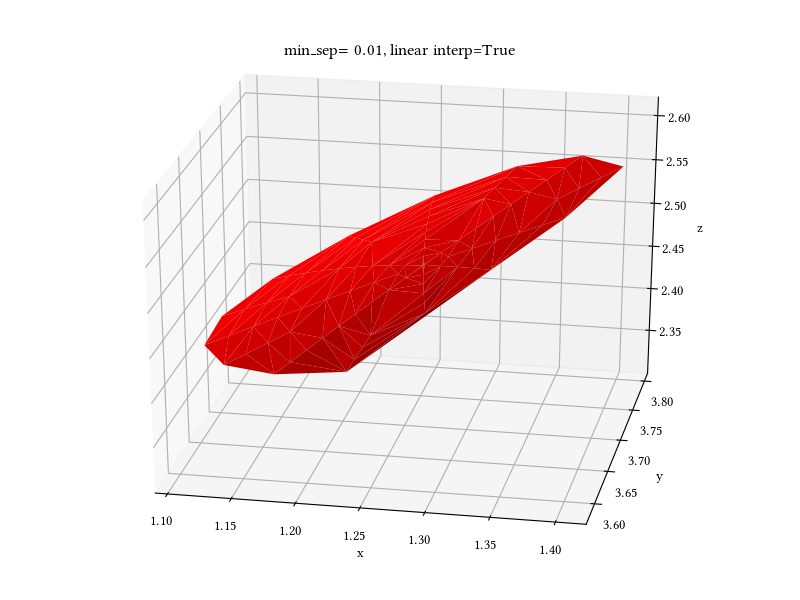

In [62]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

#s = np.linspace(0,1,1000)

#for l in mfs[1].levelsets[:]:
#    pts = np.array([l.interpolation(s0) for s0 in s])
#    ax.plot(pts[:,0], pts[:,1], pts[:,2])

cs = ['r','c','y','g']
j = 0
#for j in range(len(LCSs)):
xs = np.array([p.pos[0] for p in LCSs[j].points])
ys = np.array([p.pos[1] for p in LCSs[j].points])
zs = np.array([p.pos[2] for p in LCSs[j].points])
tris = mtri.Triangulation(xs,ys)
tris2 = []
nrms = np.empty(3)
for l in range(len(tris.triangles)):
    p0 = np.array([xs[tris.triangles[l][0]],ys[tris.triangles[l][0]],zs[tris.triangles[l][0]]])
    p1 = np.array([xs[tris.triangles[l][1]],ys[tris.triangles[l][1]],zs[tris.triangles[l][1]]])
    p2 = np.array([xs[tris.triangles[l][2]],ys[tris.triangles[l][2]],zs[tris.triangles[l][2]]])
    
    nrms[0] = np.linalg.norm(p0-p1)
    nrms[1] = np.linalg.norm(p2-p1)
    nrms[2] = np.linalg.norm(p0-p2)
    
    if np.all(np.less_equal(nrms,5*max_sep)):
        tris2.append(tris.triangles[l])
#ax.scatter(xs,ys,zs,c=cs[j])
ax.plot_trisurf(xs,ys,zs,color=cs[j],triangles = tris2,edgecolor='None',antialiased='False',linewidth=0)

#if sinusoidalsurface:
#    ax.plot_surface(np.meshgrid(x,y,indexing='ij')[0],np.meshgrid(x,y,indexing='ij')[1],np.pi+np.sin(2*np.meshgrid(x,y,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,indexing='ij')[1]))
#for l in mf.levelsets[20:40]:
#    for pts in l.points:
#        if (pts.in_AB):
#            col = 'r'
#        else:
#            col = 'k'
#        ax.scatter(pts.pos[0], pts.pos[1], pts.pos[2], c=col)
    

    
ax.set_title(r'min\_sep$={}$, linear interp={}'.format(min_sep,True))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)



plt.tight_layout()

<IPython.core.display.Javascript object>


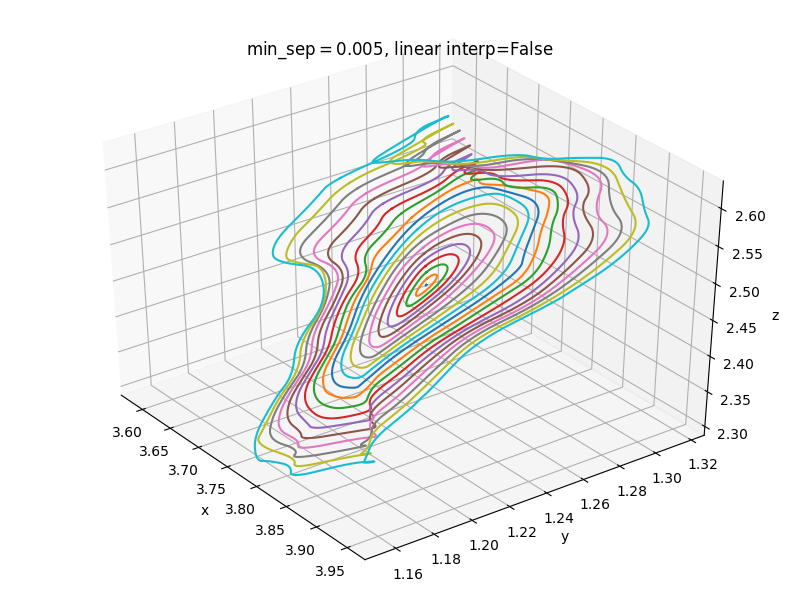

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

s = np.linspace(0,1,1000)
mf = mfs[0]

for l in mf.levelsets[:]:
    pts = np.array([l.interpolation(s0) for s0 in s])
    ax.plot(pts[:,0], pts[:,1], pts[:,2])
    
if sinusoidalsurface:
    ax.plot_surface(np.meshgrid(x,y,indexing='ij')[0],np.meshgrid(x,y,indexing='ij')[1],np.pi+np.sin(2*np.meshgrid(x,y,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,indexing='ij')[1]))
#for l in mf.levelsets[20:40]:
#    for pts in l.points:
#        if (pts.in_AB):
#            col = 'r'
#        else:
#            col = 'k'
#        ax.scatter(pts.pos[0], pts.pos[1], pts.pos[2], c=col)
    

    
ax.set_title('min_sep$={}$, linear interp={}'.format(min_sep,False))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(np.pi-0.7,np.pi+0.7)
#ax.set_ylim(np.pi-0.7,np.pi+0.7)
#ax.set_zlim(np.pi-0.7,np.pi+0.7)
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)



plt.tight_layout()

In [ ]:
def comp_msk_d():
    mask_d = np.empty((nx,ny,nz),dtype=np.bool)
    innerprod = np.empty((nx,ny,nz))
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                innerprod[i,j,k] = lm3_itp.grad(np.array([x[i],y[j],z[k]])).dot(xi3_itp(np.array([x[i],y[j],z[k]])))
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                dps = [innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                      ]
                mask_d[i,j,k] = np.any(np.less_equal([d*dps[0] for d in dps],0))
    return mask_d

In [55]:
##### Sinusoidalsurface #####

if sinusoidalsurface:
    if linear_itp:
        #xi1_itp = LinearEigenvectorInterpolator(x,y,z,xi1)
        #xi2_itp = LinearEigenvectorInterpolator(x,y,z,xi2)
        xi3_itp_sinusoid = LinearEigenvectorInterpolator(x,y,z,xi3_sinusoid)
        direction_generator = LinearAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
    else:
        #xi1_itp = SplineEigenvectorInterpolator(x,y,z,xi1,3,3,3)
        #xi2_itp = SplineEigenvectorInterpolator(x,y,z,xi2,3,3,3)
        xi3_itp_sinusoid = SplineEigenvectorInterpolator(x,y,z,xi3_sinusoid,3,3,3)
        direction_generator = SplineAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)